## **Unzip the file**

In [1]:
import zipfile

# Specify the name of the uploaded zip file
zip_file_name = '/content/drive/MyDrive/Face photos.zip'

# Specify the directory where you want to extract the contents
extract_dir = '/content/Face_photos'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Optionally, you can print a message to confirm that the extraction was successful
print("Extraction complete.")

Extraction complete.


## **Libraries**

In [2]:
# libraries for system
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



#import DL libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## **Data Preparation**

### **Running the data**

In [3]:
train_dir = '/content/Face_photos/Face photos/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    # Check if the current item is a directory
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis=1)

In [4]:
train_df

,filepaths,labels
0,/content/Face_photos/Face photos/train/disgust...,disgusted
1,/content/Face_photos/Face photos/train/disgust...,disgusted
2,/content/Face_photos/Face photos/train/disgust...,disgusted
3,/content/Face_photos/Face photos/train/disgust...,disgusted
4,/content/Face_photos/Face photos/train/disgust...,disgusted
...,...,...
28704,/content/Face_photos/Face photos/train/sad/im2...,sad
28705,/content/Face_photos/Face photos/train/sad/im3...,sad
28706,/content/Face_photos/Face photos/train/sad/im8...,sad
28707,/content/Face_photos/Face photos/train/sad/im3...,sad


In [5]:
test_dir = '/content/Face_photos/Face photos/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    # Check if the current item is a directory
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis=1)

In [6]:
test_df

,filepaths,labels
0,/content/Face_photos/Face photos/test/disguste...,disgusted
1,/content/Face_photos/Face photos/test/disguste...,disgusted
2,/content/Face_photos/Face photos/test/disguste...,disgusted
3,/content/Face_photos/Face photos/test/disguste...,disgusted
4,/content/Face_photos/Face photos/test/disguste...,disgusted
...,...,...
7173,/content/Face_photos/Face photos/test/sad/im32...,sad
7174,/content/Face_photos/Face photos/test/sad/im11...,sad
7175,/content/Face_photos/Face photos/test/sad/im79...,sad
7176,/content/Face_photos/Face photos/test/sad/im64...,sad


In [7]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Sample image from each category**

In [8]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 28709 validated image filenames belonging to 7 classes.
Found 4306 validated image filenames belonging to 7 classes.
Found 2872 validated image filenames belonging to 7 classes.


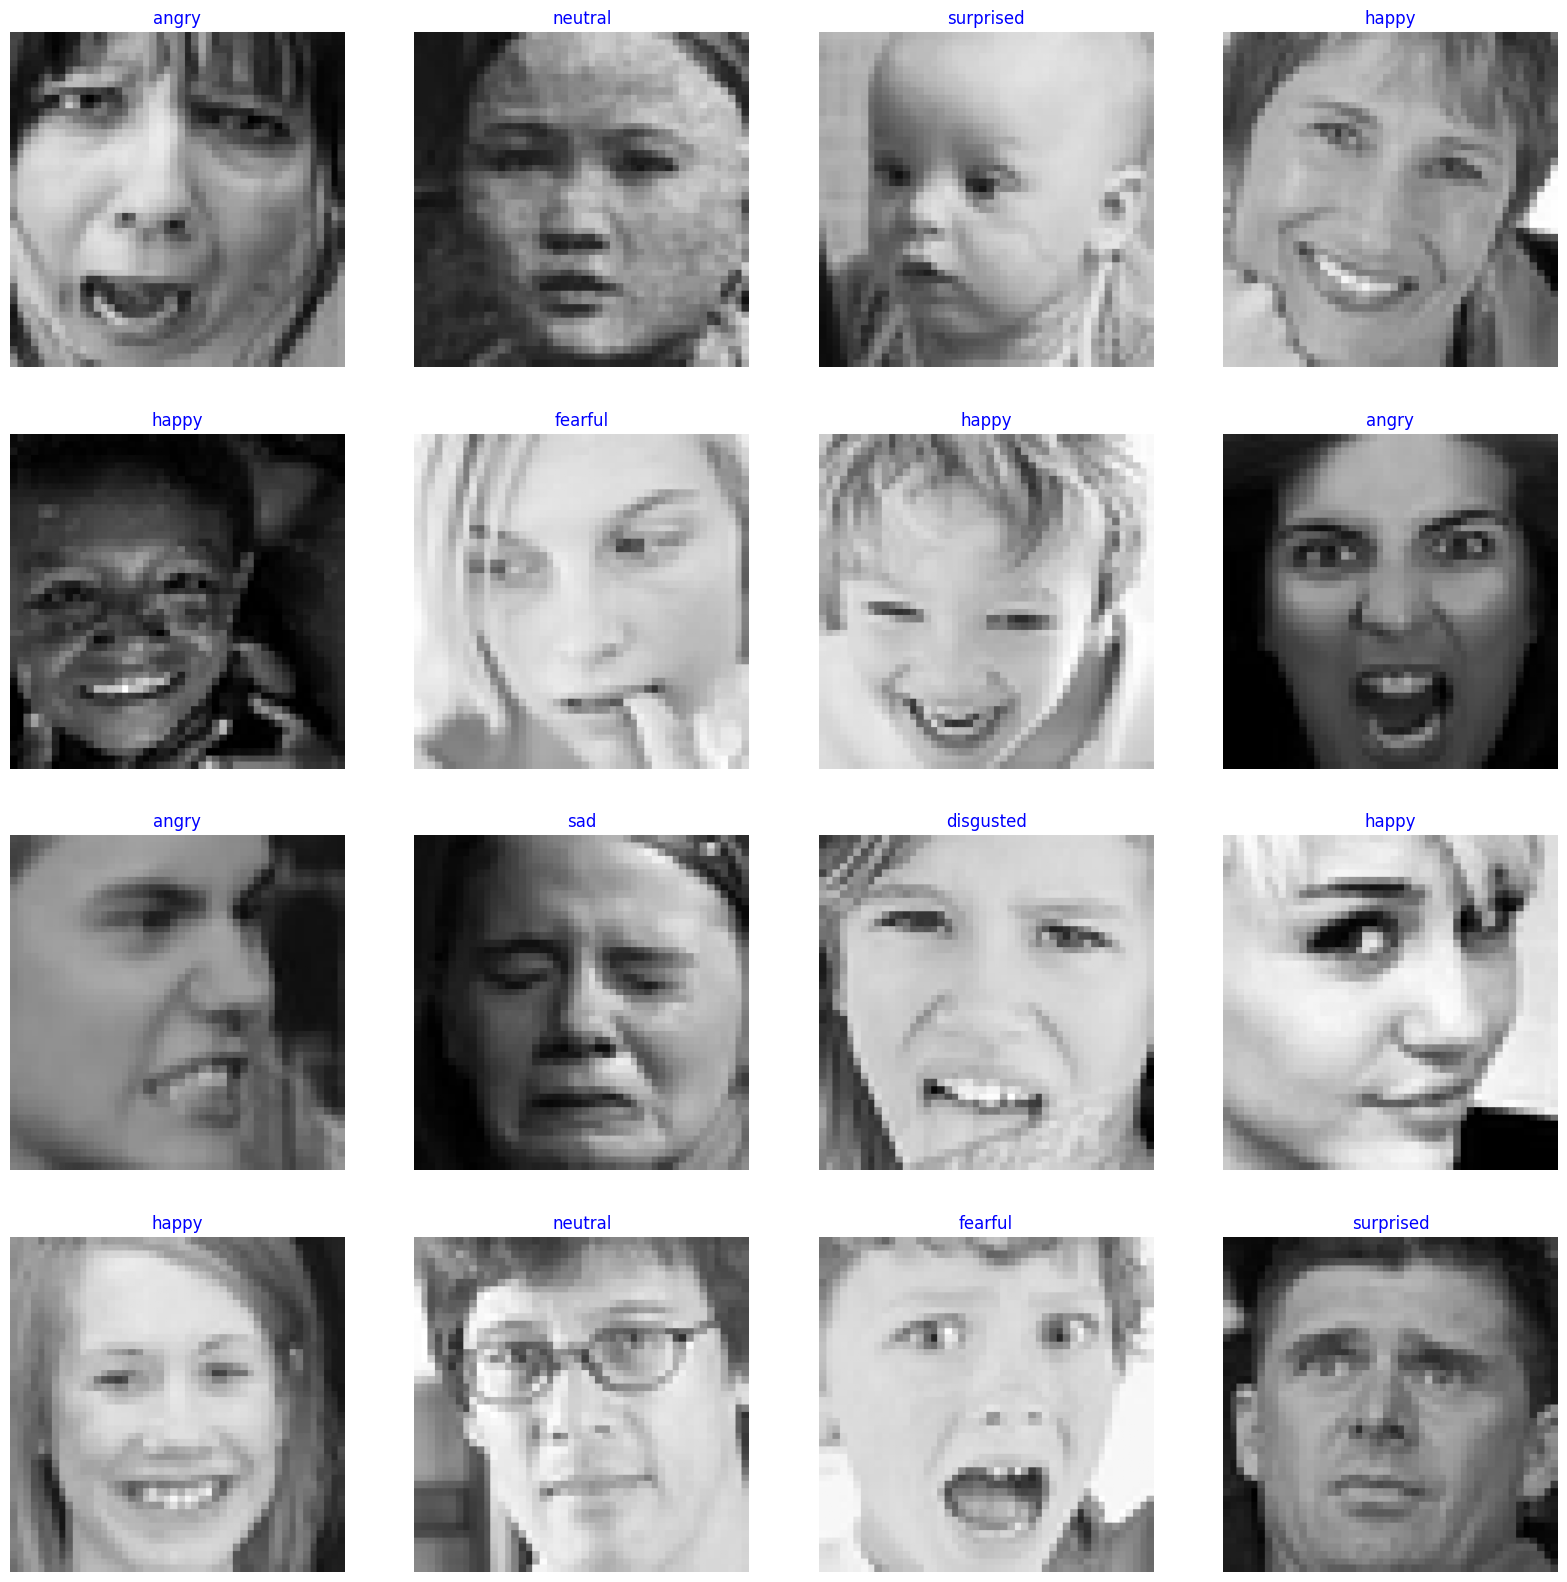

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

## **Model Building**

### **Building Model Structure**

In [10]:
#Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                       

### **Fitting our model**

In [11]:
batch_size = 20
epochs =  10

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
1795/1795 [==============================] - 1640s 849ms/step - loss: 5.0741 - accuracy: 0.4809 - val_loss: 2.2044 - val_accuracy: 0.5824
Epoch 2/10
1795/1795 [==============================] - 1555s 866ms/step - loss: 1.6750 - accuracy: 0.5947 - val_loss: 1.4020 - val_accuracy: 0.5943
Epoch 3/10
1795/1795 [==============================] - 1522s 848ms/step - loss: 1.2929 - accuracy: 0.6411 - val_loss: 1.2637 - val_accuracy: 0.6359
Epoch 4/10
1795/1795 [==============================] - 1520s 847ms/step - loss: 1.1464 - accuracy: 0.6870 - val_loss: 1.2140 - val_accuracy: 0.6577
Epoch 5/10
1795/1795 [==============================] - 1523s 848ms/step - loss: 1.0228 - accuracy: 0.7342 - val_loss: 1.1761 - val_accuracy: 0.6793
Epoch 6/10
1795/1795 [==============================] - 1522s 848ms/step - loss: 0.8774 - accuracy: 0.7859 - val_loss: 1.1442 - val_accuracy: 0.6886
Epoch 7/10
1795/1795 [==============================] - 1522s 848ms/step - loss: 0.7469 - accuracy: 0.8321

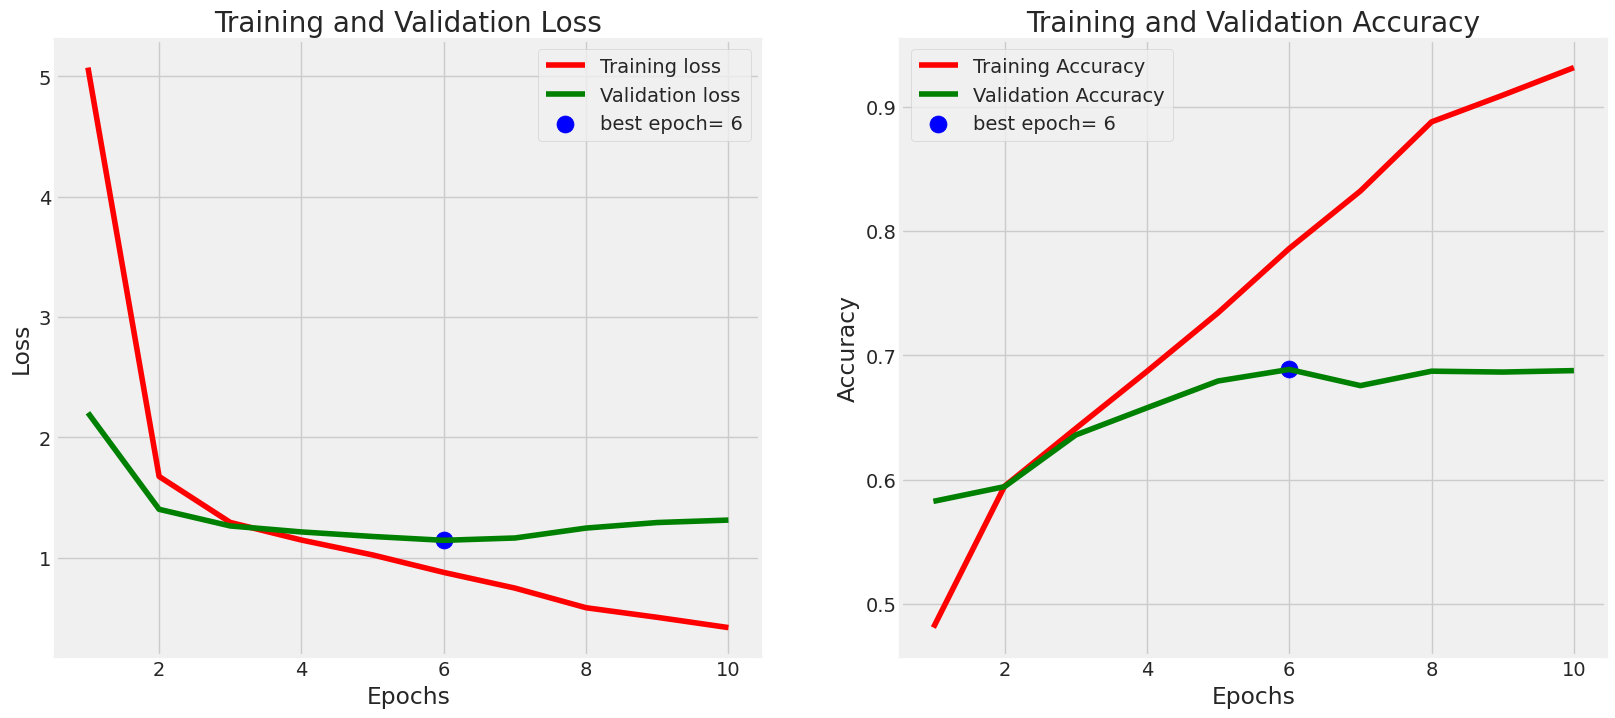

In [12]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

### **Predictions**

In [13]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

### ***Model Report***

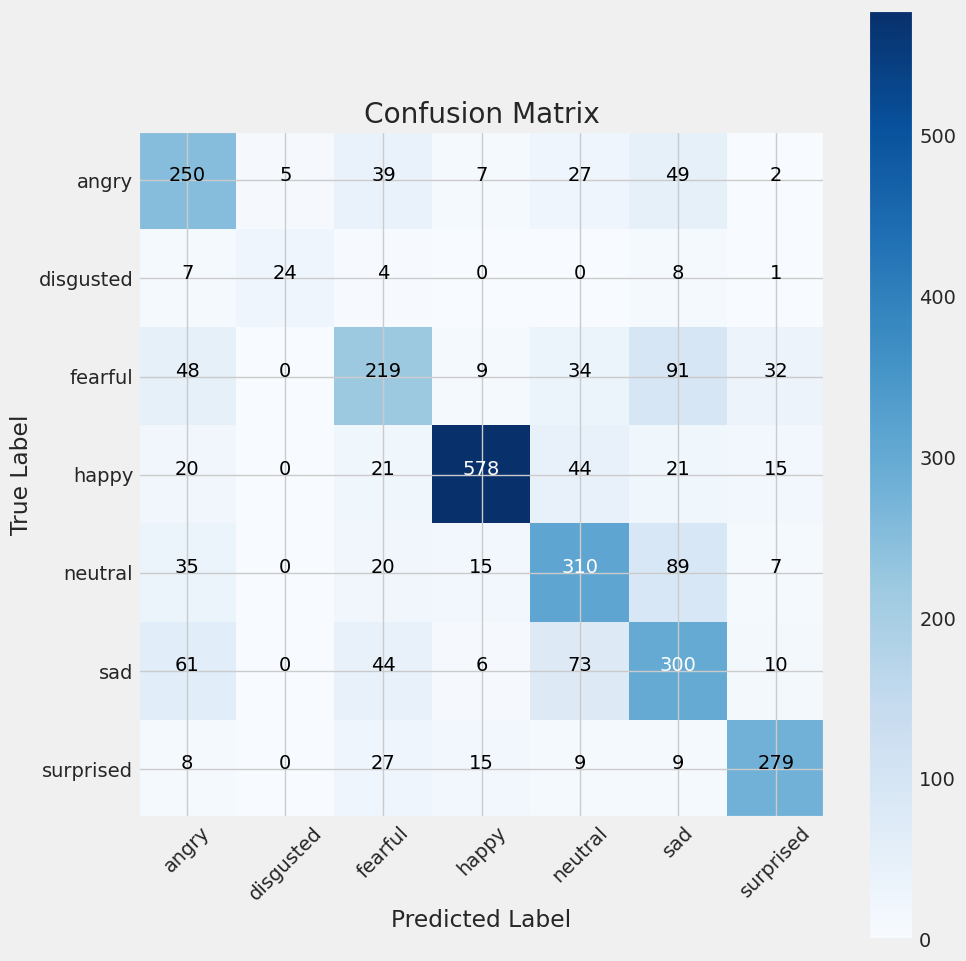

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       angry       0.58      0.66      0.62       379
   disgusted       0.83      0.55      0.66        44
     fearful       0.59      0.51      0.54       433
       happy       0.92      0.83      0.87       699
     neutral       0.62      0.65      0.64       476
         sad       0.53      0.61      0.57       494
   surprised       0.81      0.80      0.81       347

    accuracy                           0.68      2872
   macro avg       0.70      0.66      0.67      2872
weighted avg       0.69      0.68      0.69      2872



### **Saving the model and Prediction**

In [16]:
model.save("model.face_recognition")

In [17]:
loaded_model = tf.keras.models.load_model('/content/model.face_recognition', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [18]:
image_path = '/content/Face_photos/Face photos/test/happy/im0.png'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 8s 8s/step
happy


In [19]:
image_path2 = '/content/Face_photos/Face photos/test/surprised/im10.png'
image = Image.open(image_path2)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 49ms/step
surprised
